# Still missing stuff:
* Chris Mathy's favorite performance metric is not used
* Include validation data set
* If performance decreases drastically when using cellular automata, then we may want to try and use is to enrich the information already available. E.g. instead of using the original 28x28 pixels image, we may use 28x28x2 (where the extra dimension includes the image after image classification). This would most likely not decrease performance, but perhaps increase it.
* *Please add other things on this "to do list" that are missing*

# Loading packages

In [7]:
from functions import *
import cv2, keras
import numpy as np
import pandas as pd
from keras import layers
from keras.utils import np_utils
from keras.datasets import mnist
from scipy.signal import medfilt
from sklearn.preprocessing import normalize
from sklearn import svm, metrics, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
* Load MNIST
* Binarize MNIST
* Perform steps of GoL on MNIST
* *Perform steps of other cellular automata*
* Scale data

In [8]:
# Load data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Concatenate to a single dataset so that we may add validation set also
X = np.concatenate((train_X, test_X), axis=0)
y = np.concatenate((train_y, test_y), axis=0)

# Subset for faster processing
X = X[:1000]
y = y[:1000]

# Binarize (X, not y)
X_bina = np.array([make_binary(np.array(img.copy(), dtype=np.int32), 125) for img in X])

# Perform cellular automata
X_GoL = np.array([GoL(img, 3)[-1] for img in X_bina]) # Game of Life
# Add others here

# Min-max scaling
X = X/255.0
X_bina = X_bina/255.0
X_GoL = X_GoL/255.0

# Prepare lists for loop
feature_sets = [X, X_bina, X_GoL] # Add the other image processing types to this list
feature_set_names = ["X", "X_bina", "X_GoL"] # Add the other image processing types to this list

# Machine learning
* Perform LR, SVM and CNN on all feature sets
* Inspect example of performace

In [ ]:
# Perform ML on the list of feature sets
performance = ML(feature_sets, feature_set_names, y)

In [ ]:
# Inspect example of performance
performance["X_GoL"]["lr"]["classification_report"]

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.400000,0.400000,0.333333,0.363636,0.222222,0.444444,0.444444,0.571429,0.333333,0.142857,0.39,0.365570,0.373475
recall,0.363636,0.500000,0.200000,0.400000,0.333333,0.400000,0.666667,0.571429,0.400000,0.071429,0.39,0.390649,0.390000
f1-score,0.380952,0.444444,0.250000,0.380952,0.266667,0.421053,0.533333,0.571429,0.363636,0.095238,0.39,0.370770,0.374176
support,11.000000,8.000000,10.000000,10.000000,6.000000,10.000000,12.000000,14.000000,5.000000,14.000000,0.39,100.000000,100.000000


# Plots for exam paper

## MNIST example
* Example of the dataset

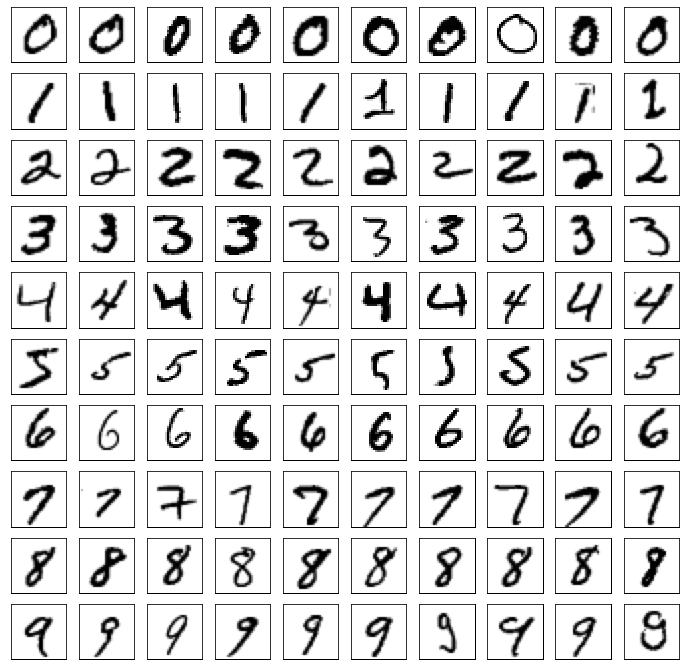

In [ ]:
# Retrieve indices for 10 samples of zeros, ones, two's, etc. ...
indices = []
for i in range(10):
    indices.append(list(np.where(y==i)[0][0:10]))

# Flatten list of indices
indices = [item for sublist in indices for item in sublist]

# Plot images with indices and save
_, axs = plt.subplots(10, 10, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(X[indices], axs):
    ax.imshow(img, cmap="gray_r") # Plot image
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'mnist_example.png'))
plt.show()

## Seed image over generations
* Showing how images evolve

### Game of Life

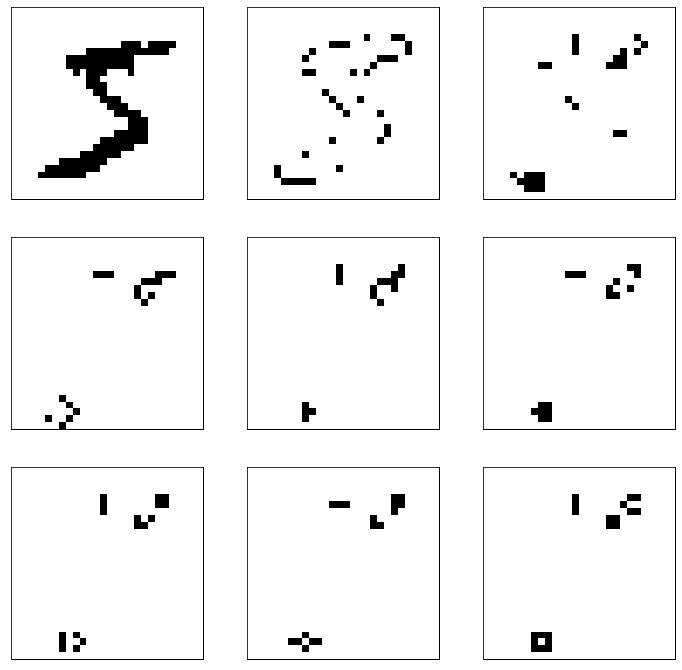

In [ ]:
# Binarize an image and make GoL generations
img = make_binary(np.array(train_X[0], dtype=np.int32), 125)
generations = GoL(img, 8)

# Plot generations and save
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generations, axs):
    ax.imshow(img, cmap="gray_r")
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'generations_example.png'), transparent = True)
plt.show()

### Corrosion

In [ ]:
# Binarize an image and make GoL generations
img = train_X[0]

# Define q(d, y) - Function that calculates impending corrosion speed - also based on y.
def Q(d, y):
    return (255 - d) * y

# Do corrosion, 8 steps
generations = corrosion(img, 8, 0.1, 6, Q)

# Plot corrosion
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generations, axs):
    ax.imshow(img, cmap="gray_r")
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'generations_example.png'), transparent = True)
plt.show()

# Extra stuff (potentially useful?)

## Test binarize and GoL functions on arbitrary image

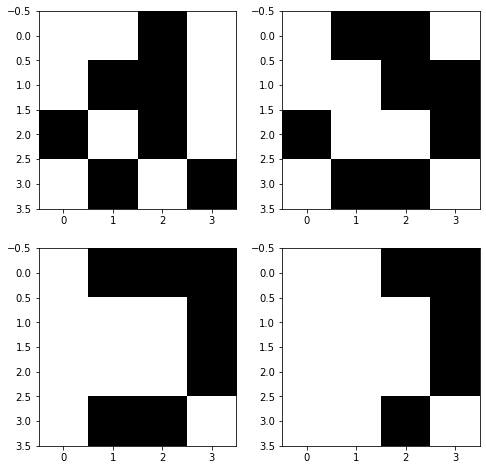

In [ ]:
# Set arbitrary seed
seed = np.array([[124, 34, 126, 0], [0, 255, 255, 74], [255, 0, 255, 0], [0, 170, 0, 178]])

# Binarize with threshold = 125
seed = make_binary(seed, 125)

# Perform 7 steps of GoL
generations = GoL(seed, 3)

# Plot generations
fig = plt.figure(figsize=(8, 8))
columns = len(generations)//2
rows = len(generations)//2
for i in range(1, len(generations)+1):
    generations[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(generations[i-1], cmap="gray_r")
plt.show()

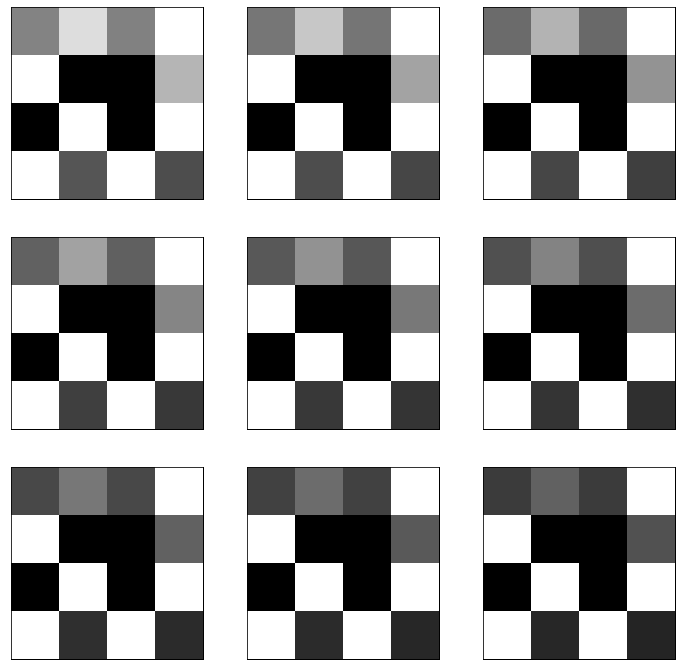

In [6]:
# Define q(d, y) - Function that calculates impending corrosion speed - also based on y.
def Q(d, y):
    return (255 - d) * y

# Define seed
seed = np.array([[124, 34, 126, 0], [0, 255, 255, 74], [255, 0, 255, 0], [0, 170, 0, 178]])

# Perform 8 steps of corrosion
generations = corrosion(seed, 8, 0.1, 6, Q)

# Plot output
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generations, axs):
    ax.imshow(img, cmap="gray_r")
    ax.axes.xaxis.set_ticklabels([]) # Remove ticklabels for both axes
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks([]) # Remove ticks (minor and major) from both axes
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.patch.set_edgecolor('black') # Border around each subplot
    ax.patch.set_linewidth('1')
plt.savefig(os.path.join('output', 'generations_example.png'), transparent = True)
plt.show()